In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import numpy as np
from keras.utils import to_categorical 
from tensorflow.keras import layers
from tensorflow import keras

In [2]:
df = pd.read_csv("table.csv")

In [3]:
df_secret = df.loc[df.expert_evaluation == 0]
df = df.loc[df.expert_evaluation != 0]

<AxesSubplot:>

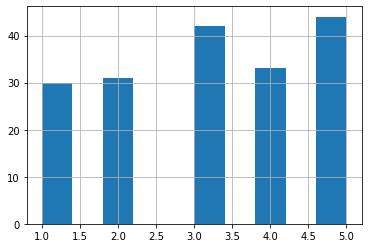

In [4]:
df.expert_evaluation.hist()

In [5]:
target_size = (64, 64)
num_samples = 180
shape = (num_samples, *target_size)

In [6]:
def png2npy(path_list, image_size):
    array = np.zeros( (len(path_list), *image_size) )
    for i in range(len(path_list)):
        img = Image.open(path_list[i]).convert('L')
        img = img.resize(image_size)
        data = np.array(img.getdata()).reshape(img.size)
        array[i, :, :] = data
    return array

In [7]:
images = png2npy(df.path_orig.values, target_size)
truth_mask = png2npy(df.path_truth_mask.values, target_size)
pred_mask = png2npy(df.path_pred_mask.values, target_size)

In [9]:
sec_images = png2npy(df_secret.path_orig.values, target_size)
sec_truth_mask = png2npy(df_secret.path_truth_mask.values, target_size)
sec_pred_mask = png2npy(df_secret.path_pred_mask.values, target_size)

In [10]:
images /= np.max(images)
truth_mask /= np.max(truth_mask)
pred_mask /= np.max(pred_mask)
y = df.expert_evaluation.values

In [11]:
sec_images /= np.max(sec_images)
sec_truth_mask /= np.max(sec_truth_mask)
sec_pred_mask /= np.max(sec_pred_mask)

In [12]:
X = np.zeros( (*images.shape, 3) )

In [13]:
X[:, :, :, 0] = pred_mask
X[:, :, :, 1] = truth_mask
X[:, :, :, 2] = images

In [14]:
X_flat = np.concatenate([pred_mask, truth_mask, images], axis=2)

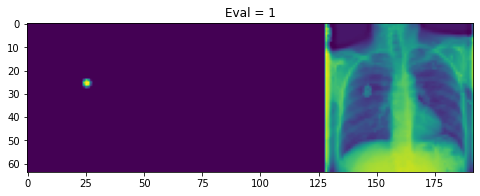

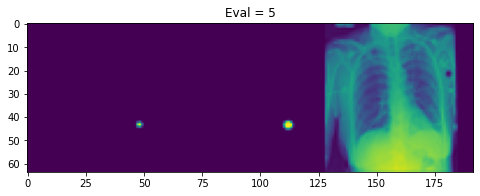

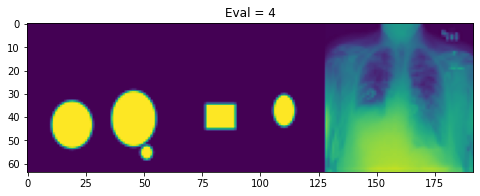

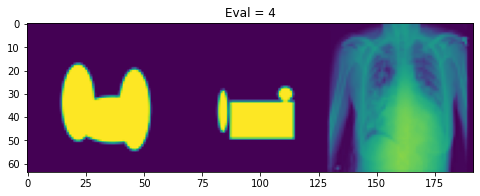

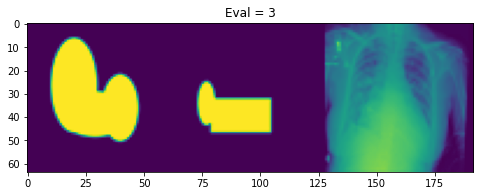

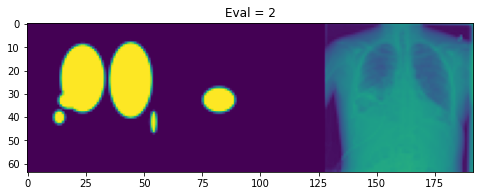

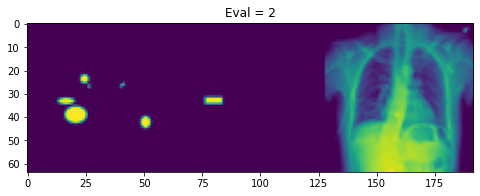

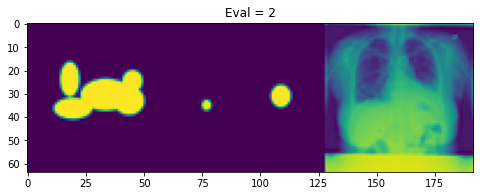

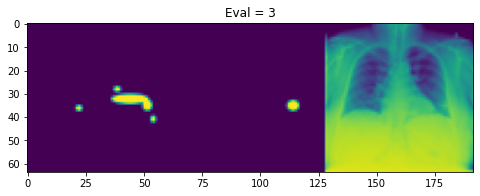

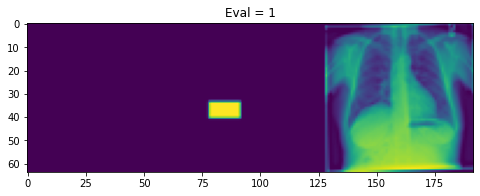

In [16]:
for i in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_title("Eval = " + str(y[i]))
    plt.imshow(X_flat[i, :, :]);

In [17]:
sss = StratifiedShuffleSplit(test_size=0.3, random_state=33)
sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [18]:
sss = StratifiedShuffleSplit(test_size=0.3, random_state=33)
sss.get_n_splits(X_flat, y)

for train_index, test_index in sss.split(X_flat, y):
    X_flat_train, X_flat_test = X_flat[train_index], X_flat[test_index]
    y_flat_train, y_flat_test = y[train_index], y[test_index]

In [19]:
num_classes = 5
input_shape = X_train[0].shape

In [20]:
y_train = to_categorical(y_train - 1, num_classes)
y_test = to_categorical(y_test - 1, num_classes)

In [22]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 3

In [23]:
batch_size = 64
epochs = 20

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/20
2/2 [==============================] - 0s 55ms/step - loss: 1.6027 - accuracy: 0.2600 - val_loss: 1.6104 - val_accuracy: 0.2308
Epoch 2/20
2/2 [==============================] - 0s 15ms/step - loss: 1.5844 - accuracy: 0.3200 - val_loss: 1.6149 - val_accuracy: 0.2308
Epoch 3/20
2/2 [==============================] - 0s 14ms/step - loss: 1.5415 - accuracy: 0.2900 - val_loss: 1.5979 - val_accuracy: 0.1923
Epoch 4/20
2/2 [==============================] - 0s 13ms/step - loss: 1.5091 - accuracy: 0.4100 - val_loss: 1.5874 - val_accuracy: 0.1923
Epoch 5/20
2/2 [==============================] - 0s 14ms/step - loss: 1.4705 - accuracy: 0.5000 - val_loss: 1.5795 - val_accuracy: 0.1923
Epoch 6/20
2/2 [==============================] - 0s 15ms/step - loss: 1.4280 - accuracy: 0.4600 - val_loss: 1.5693 - val_accuracy: 0.3077
Epoch 7/20
2/2 [==============================] - 0s 14ms/step - loss: 1.3526 - accuracy: 0.6100 - val_loss: 1.5632 - val_accuracy: 0.3077
Epoch 8/20
2/2 [===========

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.0608956813812256
Test accuracy: 0.3888888955116272
